In [55]:
import pandas as pd
import numpy as np

gdata_df = pd.read_csv('GData.csv')
activity_df = pd.read_excel('Activity_01012022_31032022.xlsx', sheet_name='Sheet1')


#joiing delivery schedule lines with gdata on EBELN and EBELP
# in gdata 76412, in deliv_Df 12394 common 12159 on PO number and item number
delivery_schedule_lines_df = pd.read_excel('Delivery Schedule Lines of a Purchasing Document.xlsx')
df= delivery_schedule_lines_df.groupby(['Purchasing Document Number', 'Item Number of Purchasing Document'])['Delivery Date of Vendor Confirmation'].max().reset_index()

merged_df = gdata_df.merge(df, left_on=['EBELN', 'EBELP'], right_on=['Purchasing Document Number', 'Item Number of Purchasing Document'], how='left')
#joining scheduling_agreement_schedule_lines_df with merged_df
scheduling_agreement_schedule_lines_df = pd.read_excel('Scheduling Agreement Schedule Lines.xlsx')
df=scheduling_agreement_schedule_lines_df.groupby(['Purchasing Document Number', 'Item Number of Purchasing Document'])['Item Delivery Date'].max()
df=pd.DataFrame(df).reset_index()

merged_df = merged_df.merge(df[['Purchasing Document Number', 'Item Number of Purchasing Document', 'Item Delivery Date']], 
                            left_on=['EBELN', 'EBELP'], 
                            right_on=['Purchasing Document Number', 'Item Number of Purchasing Document'], 
                            how='left')
# Create a new column 'expected_delivery_date' with default value as 'Item Delivery Date'
merged_df['expected_delivery_date'] = merged_df['Item Delivery Date']

# Replace the values with 'Delivery Date of Vendor Confirmation' where it is not null
merged_df.loc[merged_df['Delivery Date of Vendor Confirmation'].notnull(), 'expected_delivery_date'] = merged_df['Delivery Date of Vendor Confirmation']


#Adding expected_GR_days and delay_flag column to the merged_df
merged_df['expected_GR_days'] = (pd.to_datetime(merged_df['expected_delivery_date']) - pd.to_datetime(merged_df['createtime'])).dt.days
merged_df['GR_delay'] = merged_df['GDdays'] - merged_df['expected_GR_days']
merged_df['GR_delay_flag'] = merged_df['GR_delay'].apply(lambda x: 1 if x > 0 else 0)

#column_order = ['X_CASE_KEY', 'EBELN', 'EBELP', 'createtime', 'firstreceivetime', 'Delivery Date of Vendor Confirmation', 'GDdays', 'expected_GR_days', 'GR_delay', 'changeconfirmeddeliverydate', 'changecontract', 'changecurrency', 'changedeliveryindicator', 'changefinalinvoiceindicator', 'changeoutwarddeliveryindicator', 'changeprice', 'changequantity', 'changerequesteddeliverydate', 'changestoragelocation', 'numdelivery', 'BUKRS', 'MATKL', 'MATNR', 'NETPR', 'PSTYP', 'WERKS', 'ERNAM', 'GR_delay_flag']

#merged_df = merged_df.reindex(columns=column_order)

# Transform GDdays and GR_delay columns
merged_df['GDdays_log'] = np.log(merged_df['GDdays'] + 1)
merged_df['GR_delay_log'] = np.where(merged_df['GR_delay'] > 0, np.log(merged_df['GR_delay'] + 1), 0)
#join PR table to get PR to PO delay, and creation indicator
#gdata=76412 purchase_requisition_df=45179 commmon 37339 on POnumber and item number
#'Creation Indicator (Purchase Requisition/Schedule Lines)' and prtoPOdelay use in regression model
purchase_requisition_df = pd.read_excel('Purchase Requisition.xlsx')
order_delay = purchase_requisition_df.groupby(['Purchase Order Number', 'Item Number of Purchasing Document','Creation Indicator (Purchase Requisition/Schedule Lines)']).apply(lambda x: (x['Purchase Order Date'] - x['Requisition (Request) Date']).max()).reset_index()
order_delay.columns = ['Purchase Order Number', 'Item Number of Purchasing Document','Creation Indicator (Purchase Requisition/Schedule Lines)', 'PR_to_PO_delay']
merged_df = merged_df.merge(order_delay, left_on=['EBELN', 'EBELP'], right_on=['Purchase Order Number', 'Item Number of Purchasing Document'], how='left')
merged_df['PR_to_PO_delay'] = merged_df['PR_to_PO_delay'].dt.days
#join with purchasing document header to get Vendor and Currency information
purchasing_document_header_df = pd.read_excel('Purchasing Document Header.xlsx')
merged_df = merged_df.merge(purchasing_document_header_df[['Purchasing Document Number', 'Purchasing Group', 'Purchasing Organization', 'Vendor Account Number', 'Currency Key', 'Exchange Rate']], 
                            left_on='EBELN', right_on='Purchasing Document Number', how='left')
merged_df=merged_df[['X_CASE_KEY', 'EBELN', 'EBELP', 'createtime', 'firstreceivetime',
    'changeconfirmeddeliverydate', 'changecontract', 'changecurrency',
    'changedeliveryindicator', 'changefinalinvoiceindicator',
    'changeoutwarddeliveryindicator', 'changeprice', 'changequantity',
    'changerequesteddeliverydate', 'changestoragelocation', 'numdelivery',
    'GDdays', 'BUKRS', 'MATKL', 'MATNR', 'NETPR', 'PSTYP', 'WERKS', 'ERNAM',       
    'Delivery Date of Vendor Confirmation', 'Item Delivery Date',
    'expected_delivery_date', 'expected_GR_days', 'GR_delay',
    'GR_delay_flag', 'GDdays_log', 'GR_delay_log',
    'Creation Indicator (Purchase Requisition/Schedule Lines)',
    'PR_to_PO_delay', 'Purchasing Document Number', 'Purchasing Group',
    'Purchasing Organization', 'Vendor Account Number', 'Currency Key',
    'Exchange Rate']]
#total invoice value, and quantity
#purchasing_document_item_df 86402 gdata and merged 76412 
purchasing_document_item_df = pd.read_excel('Purchasing Document Item.xlsx')
selected_columns = ['Purchasing Document Number', 'Item Number of Purchasing Document', 'Storage Location', 'Price Unit', 'Purchase Order Unit of Measure', 'Net Price in Purchasing Document (in Document Currency)', 'Net Order Value in PO Currency']
purchasing_document_item_df['Quantity'] = purchasing_document_item_df['Net Order Value in PO Currency'] / purchasing_document_item_df['Net Price in Purchasing Document (in Document Currency)']
selected_df = purchasing_document_item_df[selected_columns + ['Quantity']]

# Perform left join without specifying suffixes
merged_df = merged_df.merge(selected_df, how='left', left_on=['EBELN', 'EBELP'], right_on=['Purchasing Document Number', 'Item Number of Purchasing Document'])
merged_df=merged_df[['EBELN', 'EBELP', 'createtime', 'firstreceivetime','expected_delivery_date','expected_GR_days', 'GR_delay',
       'GR_delay_flag', 'GDdays_log', 'GR_delay_log',
       'changeconfirmeddeliverydate', 'changecontract', 'changecurrency',
       'changedeliveryindicator', 'changefinalinvoiceindicator',
       'changeoutwarddeliveryindicator', 'changeprice', 'changequantity',
       'changerequesteddeliverydate', 'changestoragelocation', 'numdelivery',
       'GDdays', 'BUKRS', 'MATKL', 'MATNR', 'NETPR', 'PSTYP', 'WERKS', 'ERNAM',
       'Delivery Date of Vendor Confirmation', 'Item Delivery Date', 
       'Creation Indicator (Purchase Requisition/Schedule Lines)',
       'PR_to_PO_delay', 'Purchasing Group',
       'Purchasing Organization', 'Vendor Account Number', 'Currency Key',
       'Exchange Rate', 'Storage Location', 'Price Unit',
       'Purchase Order Unit of Measure',
       'Net Price in Purchasing Document (in Document Currency)',
       'Net Order Value in PO Currency', 'Quantity']]

merged_df['NETPR_normalized'] = merged_df['NETPR'] * merged_df['Exchange Rate']

merged_df.dropna(subset='GDdays', inplace=True)

n = 500

# Define the bin edges
bins = [3*i for i in range(n)]
bins_neg = [3*i for i in range(-n,n)]

labels = range(1, n)
labels_neg = range(-n+1, n)

# Bin the values in the 'expected_GR_days' column
merged_df['expected_GR_days_bin'] = pd.cut(merged_df['expected_GR_days'], bins=bins, labels=labels, right=False)
merged_df['GR_delay_bin'] = pd.cut(merged_df['GR_delay'], bins=bins_neg, labels=labels_neg, right=False)
merged_df['GDdays_bin'] = pd.cut(merged_df['GDdays'], bins=bins, labels=labels, right=False)
merged_df['GR_delay_flag_bin'] = merged_df['GR_delay_bin'].apply(lambda x: 1 if x > 1 else 0)

C:\Users\bolusani\AppData\Local\Temp\ipykernel_15096\459781769.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['expected_GR_days'] = (pd.to_datetime(merged_df['expected_delivery_date']) - pd.to_datetime(merged_df['createtime'])).dt.days
C:\Users\bolusani\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bolusani\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bolusani\AppData\Local\Temp\ipykernel_15096\459781769.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

In [ ]:
#Handling missing values 
#merged_df[['expected_GR_days_bin', 'expected_GR_days']][merged_df['expected_GR_days_bin'].isnull()].describe()

merged_df['PR_to_PO_delay_not_null_flag'] = merged_df['PR_to_PO_delay'].notnull().astype(int)
columns_fill_zero = ['PR_to_PO_delay']
merged_df[columns_fill_zero] = merged_df[columns_fill_zero].fillna(0)
merged_df['expected_GR_days_not_neg_flag'] = merged_df['expected_GR_days_bin'].notnull().astype(int)
merged_df['Vendor Account Number'].fillna(1, inplace=True)
merged_df['Quantity'].fillna(0, inplace=True)
merged_df['expected_GR_days_bin'] = merged_df['expected_GR_days_bin'].astype(float)
merged_df['expected_GR_days_bin'].fillna(-1, inplace=True)


In [62]:
import pandas as pd

# Create the DataFrame
merged_df_null_counts = pd.DataFrame({
    'Column Name': merged_df.columns,
    'No. of Null Values': merged_df.isnull().sum()
})

merged_df_null_counts.sort_values(by='No. of Null Values', ascending=False, inplace=True)
merged_df_null_counts[merged_df_null_counts['No. of Null Values']!=0]



,Column Name,No. of Null Values
Delivery Date of Vendor Confirmation,Delivery Date of Vendor Confirmation,64249
MATNR,MATNR,56390
Storage Location,Storage Location,55699
ERNAM,ERNAM,39073
Creation Indicator (Purchase Requisition/Schedule Lines),Creation Indicator (Purchase Requisition/Sched...,39073


In [67]:

merged_df.columns


Index(['EBELN', 'EBELP', 'createtime', 'firstreceivetime',
       'expected_delivery_date', 'expected_GR_days', 'GR_delay',
       'GR_delay_flag', 'GDdays_log', 'GR_delay_log',
       'changeconfirmeddeliverydate', 'changecontract', 'changecurrency',
       'changedeliveryindicator', 'changefinalinvoiceindicator',
       'changeoutwarddeliveryindicator', 'changeprice', 'changequantity',
       'changerequesteddeliverydate', 'changestoragelocation', 'numdelivery',
       'GDdays', 'BUKRS', 'MATKL', 'MATNR', 'NETPR', 'PSTYP', 'WERKS', 'ERNAM',
       'Delivery Date of Vendor Confirmation', 'Item Delivery Date',
       'Creation Indicator (Purchase Requisition/Schedule Lines)',
       'PR_to_PO_delay', 'Purchasing Group', 'Purchasing Organization',
       'Vendor Account Number', 'Currency Key', 'Exchange Rate',
       'Storage Location', 'Price Unit', 'Purchase Order Unit of Measure',
       'Net Price in Purchasing Document (in Document Currency)',
       'Net Order Value in PO Currenc

EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
data=merged_df.copy()

# Convert to a suitable data type for categorical/binary features
for col in ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']:
    data[col] = data[col].astype('category')

# Descriptive statistics for numerical features
numerical_features = ['expected_GR_days', 'NETPR_normalized', 'Quantity', 'PR_to_PO_delay', 'GR_delay_log']
binary_features = ['changerequesteddeliverydate', 'changeprice', 'changequantity', 
                   'changecurrency', 'changedeliveryindicator', 'changefinalinvoiceindicator', 
                   'changestoragelocation', 'changeconfirmeddeliverydate', 
                   'changecontract', 'changeoutwarddeliveryindicator']
# Correlation Matrix
correlation_features = numerical_features + ['GR_delay_bin']
corr_matrix = data[correlation_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

print(data[numerical_features].describe())

# Distribution of numerical features
for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Bar plots for binary features

for col in binary_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=data)
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()




In [77]:
import pandas as pd
import locale
data=merged_df.copy()

# Assume data is your DataFrame and it's properly loaded

# 1. Calculate the sum of the product of 'Net Order Value in PO Currency' and 'Exchange Rate'
total_value_converted = (data['Net Order Value in PO Currency']).sum()

# 2. Count the total number of unique plants in 'WERKS'
total_plants = data['WERKS'].nunique()

# 3. Count the total number of unique vendors in 'Vendor Account Number'
total_vendors = data['Vendor Account Number'].nunique()

# 4. Count the total number of unique material groups in 'MATKL'
total_material_groups = data['MATKL'].nunique()

# 5. Sum up the 'GR_delay_flag_bin' column
sum_gr_delay_flag_bin = data['GR_delay_flag_bin'].sum()
# Set the locale to the desired currency format
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')



# Print the results
print(f"Total Invoice Value Converted: {locale.currency(total_value_converted, grouping=True)}")
print(f"Total Number of Plants: {total_plants}")
print(f"Total Number of Vendors: {total_vendors}")
print(f"Total Number of Material Groups: {total_material_groups}")
print(f"Delayed_GR_count: {sum_gr_delay_flag_bin}")
print("Total number of PO:", data['EBELN'].nunique())
print("Total number of records:", data.shape[0])



Total Invoice Value Converted: $2,830,943,809.90
Total Number of Plants: 166
Total Number of Vendors: 2971
Total Number of Material Groups: 634
Sum of GR_delay_flag_bin: 19275
Total number of PO: 50186
Total number of records: 76408


In [80]:
import pandas as pd

# Assuming 'data' is your DataFrame

# List of change columns
change_columns = [
    "changeconfirmeddeliverydate", "changecontract", "changecurrency", 
    "changedeliveryindicator", "changefinalinvoiceindicator", 
    "changeoutwarddeliveryindicator", "changeprice", "changequantity", 
    "changerequesteddeliverydate", "changestoragelocation"
]

# Create 'any_change_flag' by summing up all the change columns
data['any_change_flag'] = data[change_columns].sum(axis=1)
change_columns = change_columns + ['any_change_flag']
# Now, calculate sum and count of 'GR_delay_flag_bin' where each change column is greater than 0
results = {}
for column in change_columns:
    filtered_data = data[data[column] > 0]
    results[column] = {
        'sum_GR_delay_flag_bin': filtered_data['GR_delay_flag_bin'].sum(),
        'count_GR_delay_flag_bin': filtered_data['GR_delay_flag_bin'].count()
    }

# Print the results
for column, result in results.items():
    print(f"Results for {column}:")
    print(f"  Sum of GR_delay_flag_bin({round(result['sum_GR_delay_flag_bin']*100/result['count_GR_delay_flag_bin'],0)}%): {result['sum_GR_delay_flag_bin']}/{result['count_GR_delay_flag_bin']}")
    


Results for changeconfirmeddeliverydate:
  Sum of GR_delay_flag_bin(34.0%): 12/35
Results for changecontract:
  Sum of GR_delay_flag_bin(44.0%): 20/45
Results for changecurrency:
  Sum of GR_delay_flag_bin(71.0%): 10/14
Results for changedeliveryindicator:
  Sum of GR_delay_flag_bin(44.0%): 432/991
Results for changefinalinvoiceindicator:
  Sum of GR_delay_flag_bin(45.0%): 68/150
Results for changeoutwarddeliveryindicator:
  Sum of GR_delay_flag_bin(43.0%): 107/248
Results for changeprice:
  Sum of GR_delay_flag_bin(39.0%): 1545/3939
Results for changequantity:
  Sum of GR_delay_flag_bin(42.0%): 961/2268
Results for changerequesteddeliverydate:
  Sum of GR_delay_flag_bin(28.0%): 1838/6515
Results for changestoragelocation:
  Sum of GR_delay_flag_bin(41.0%): 70/169
Results for any_change_flag:
  Sum of GR_delay_flag_bin(35.0%): 3880/11009


Random forest for feature selection

Mean Squared Error: 1.0629904113543667
Root Mean Squared Error: 1.0310142634097583


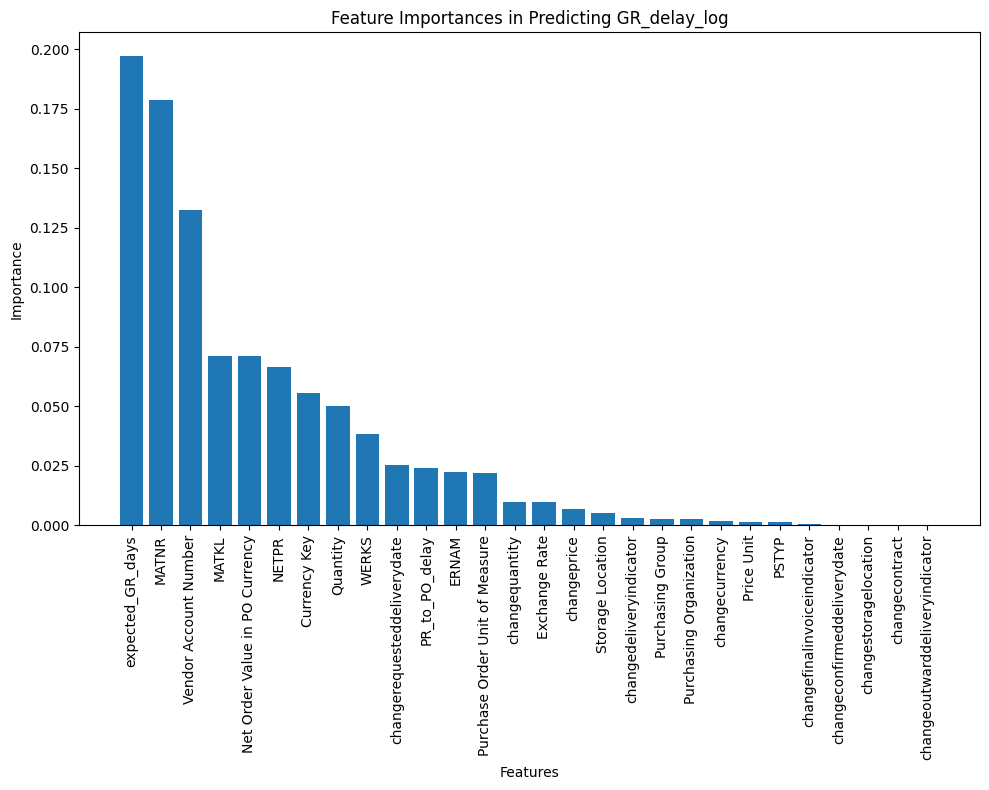

In [63]:
##Preprocess the Data
data=merged_df.copy()
# Columns to be ignored (dropped) from the analysis
#data.drop(columns=['Delivery Date of Vendor Confirmation'], inplace=True)

# Columns where rows with null values should be removed
columns_remove_rows = [
    'MATNR', 'Storage Location', 'Creation Indicator (Purchase Requisition/Schedule Lines)',
    'Quantity', 'Vendor Account Number', 'GDdays', 'GR_delay', 'GDdays_log','PR_to_PO_delay'
]
data.dropna(subset=columns_remove_rows, inplace=True)

# Columns where null values should be filled with 0
columns_fill_zero = ['PR_to_PO_delay', 'ERNAM']
data[columns_fill_zero] = data[columns_fill_zero].fillna(0)


numerical_variables = [
    "expected_GR_days", "NETPR", 
    "Net Order Value in PO Currency", "Quantity", 
    "Price Unit", "Exchange Rate","PR_to_PO_delay"
]

# List of nominal variables
nominal_variables = [
    "MATNR", "MATKL", "PSTYP", "WERKS", "ERNAM", "Purchasing Group", 
    "Purchasing Organization", "Vendor Account Number", 
    "Currency Key", "Storage Location", "Purchase Order Unit of Measure"
]

# List of binary variables
binary_variables = [
     "changeconfirmeddeliverydate", "changecontract", 
    "changecurrency", "changedeliveryindicator", "changefinalinvoiceindicator", 
    "changeoutwarddeliveryindicator", "changeprice", "changequantity", 
    "changerequesteddeliverydate", "changestoragelocation"
]

##Feature Importance
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Assuming 'data' is your DataFrame loaded from the CSV
# and it's been preprocessed to handle missing values in the columns

# Encode categorical variables using Label Encoding
label_encoders = {}
for column in nominal_variables:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# Prepare the data for modeling
X = data[numerical_variables + nominal_variables + binary_variables]
y = data['GR_delay_log']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


import matplotlib.pyplot as plt
import numpy as np

# Feature names from the model
feature_names = numerical_variables + nominal_variables + binary_variables

# Extract feature importances from the model
importances = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
sorted_feature_names = [feature_names[i] for i in indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.title("Feature Importances in Predicting GR_delay_log")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.tight_layout()  # adjusts subplots to give some padding
plt.show()




In [8]:
data[['expected_GR_days', 'Vendor Account Number', 'MATKL', 'NETPR_normalized_scaled', 
          'Currency Key', 'Quantity', 'WERKS','PR_to_PO_delay'] + 
          ['changerequesteddeliverydate', 'changeprice', 'changequantity', 
          'changecurrency', 'changedeliveryindicator', 'changefinalinvoiceindicator', 
          'changestoragelocation', 'changeconfirmeddeliverydate', 
          'changecontract', 'changeoutwarddeliveryindicator']]

Regression

In [106]:
data=merged_df.copy()
# Apply log transformation to the normalized values
data['NETPR_normalized_log'] = np.log(data['NETPR_normalized'])
# Apply scaling to the normalized values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['NETPR_normalized_scaled'] = scaler.fit_transform(data['NETPR_normalized'].values.reshape(-1, 1))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
# Encode categorical variables
label_encoders = {}
for column in ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

C:\Users\bolusani\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [115]:
Q1 = data['GR_delay_bin'].quantile(0.1)
Q3 = data['GR_delay_bin'].quantile(0.9)
IQR = Q3 - Q1
Q1,Q3,IQR,Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
#data = data[(data['GR_delay_bin'] >= Q1 - 1.5 * IQR) & (data['GR_delay_bin'] <= Q3 + 1.5 * IQR)]


(-2.0, 6.0, 8.0, -14.0, 18.0)

In [109]:
Q1 - 1.5 * IQR

1.0

In [108]:
data = data[(data['GR_delay_bin'] >= -9) & (data['GR_delay_bin'] <= 18)]


count    76408.000000
mean         0.799890
std         13.477512
min       -412.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        349.000000
Name: GR_delay_bin, dtype: float64

In [118]:
data['GR_delay_bin']=data['GR_delay_bin'].astype(int)
data[data['GR_delay_bin']<-9].shape[0],data[data['GR_delay_bin']>18].shape[0], data.shape[0]

(2639, 2202, 76408)

In [65]:
final_data_regression = data[['expected_GR_days', 'Vendor Account Number', 'MATKL', 'NETPR_normalized_scaled', 
          'Currency Key', 'Quantity', 'WERKS','PR_to_PO_delay'] + 
          ['changerequesteddeliverydate', 'changeprice', 'changequantity', 
          'changecurrency', 'changedeliveryindicator', 'changefinalinvoiceindicator', 
          'changestoragelocation', 'changeconfirmeddeliverydate', 
          'changecontract', 'changeoutwarddeliveryindicator']]
#final_data_regression.to_csv('final_data_regression.csv', index=False)
Y=data['GR_delay_log']


MLP

In [ ]:
data=merged_df.copy()
change_columns = [
    "changeconfirmeddeliverydate", "changecontract", "changecurrency", 
    "changedeliveryindicator", "changefinalinvoiceindicator", 
    "changeoutwarddeliveryindicator", "changeprice", "changequantity", 
    "changerequesteddeliverydate", "changestoragelocation"
]

# Create 'any_change_flag' by summing up all the change columns
data['any_change_flag'] = data[change_columns].sum(axis=1)
# Apply log transformation to the normalized values
data['NETPR_normalized_log'] = np.log(data['NETPR_normalized'])
# Apply scaling to the normalized values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['NETPR_normalized_scaled'] = scaler.fit_transform(data['NETPR_normalized'].values.reshape(-1, 1))
data['any_change_flag'] = data[change_columns].sum(axis=1)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
# Encode categorical variables
label_encoders = {}
for column in ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le
#data=data[(data['PR_to_PO_delay_not_null_flag']!=0) & (data['expected_GR_days_not_neg_flag']!=0)]
data = data[(data['GR_delay_bin'] >= -9) & (data['GR_delay_bin'] <= 18)]
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Load and preprocess the data
categorical_features = ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']

# Concatenate encoded df with the rest of the data
numerical_features = ['expected_GR_days', 'NETPR', 'Quantity', 'PR_to_PO_delay'] + \
    ['any_change_flag','changerequesteddeliverydate', 'changeprice', 'changequantity', 'changecurrency', 
     'changedeliveryindicator', 'changefinalinvoiceindicator', 'changestoragelocation', 
     'changeconfirmeddeliverydate', 'changecontract', 'changeoutwarddeliveryindicator','PR_to_PO_delay_not_null_flag',
       'expected_GR_days_not_neg_flag']

print("total records in data",data.shape[0])
final_data_regression = data[numerical_features + categorical_features]
#Y = data['GR_delay_bin'].astype(int)
Y = data['GR_delay_log']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_data_regression, Y, test_size=0.2, random_state=42)


In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize and train the MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train, y_train)

# Predict using the test set
y_pred = mlp.predict(X_test)

# Calculate and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

print("the model is not able to capture the underlying patterns in the data and is not able to make accurate predictions.")


Mean Squared Error: 4586164.747761482
R^2 Score: -5051758.032396144
the model is not able to capture the underlying patterns in the data and is not able to make accurate predictions.


XGboost

In [149]:
data=merged_df.copy()
change_columns = [
    "changeconfirmeddeliverydate", "changecontract", "changecurrency", 
    "changedeliveryindicator", "changefinalinvoiceindicator", 
    "changeoutwarddeliveryindicator", "changeprice", "changequantity", 
    "changerequesteddeliverydate", "changestoragelocation"
]

# Create 'any_change_flag' by summing up all the change columns
data['any_change_flag'] = data[change_columns].sum(axis=1)
# Apply log transformation to the normalized values
data['NETPR_normalized_log'] = np.log(data['NETPR_normalized'])
# Apply scaling to the normalized values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['NETPR_normalized_scaled'] = scaler.fit_transform(data['NETPR_normalized'].values.reshape(-1, 1))
data['any_change_flag'] = data[change_columns].sum(axis=1)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
# Encode categorical variables
label_encoders = {}
for column in ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le
#data=data[(data['PR_to_PO_delay_not_null_flag']!=0) & (data['expected_GR_days_not_neg_flag']!=0)]
data = data[(data['GR_delay_bin'] >= -9) & (data['GR_delay_bin'] <= 18)]
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Load and preprocess the data
categorical_features = ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']

# Concatenate encoded df with the rest of the data
numerical_features = ['expected_GR_days', 'NETPR', 'Quantity', 'PR_to_PO_delay'] + \
    ['any_change_flag','changerequesteddeliverydate', 'changeprice', 'changequantity', 'changecurrency', 
     'changedeliveryindicator', 'changefinalinvoiceindicator', 'changestoragelocation', 
     'changeconfirmeddeliverydate', 'changecontract', 'changeoutwarddeliveryindicator','PR_to_PO_delay_not_null_flag',
       'expected_GR_days_not_neg_flag']

print("total records in data",data.shape[0])
final_data_regression = data[numerical_features + categorical_features]
#Y = data['GR_delay_bin'].astype(int)
Y = data['GR_delay_log']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_data_regression, Y, test_size=0.2, random_state=42)


total records in data 71567


C:\Users\bolusani\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mean Squared Error: 0.5470498637486627
R² Score: 0.3974128182568475


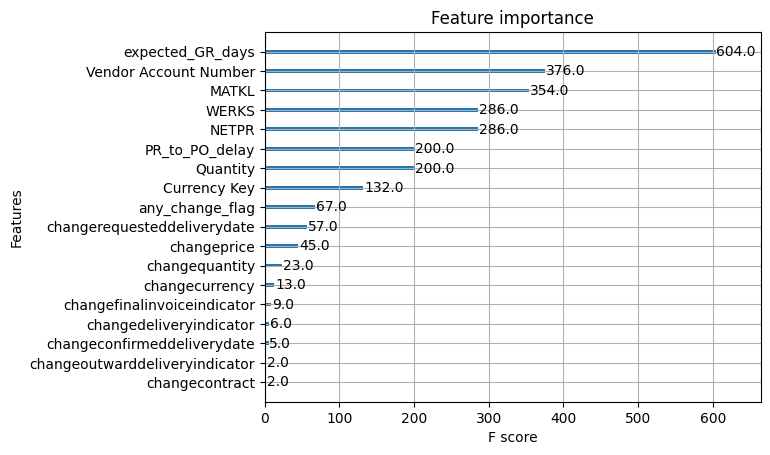

In [150]:

import xgboost as xgb

# Define the XGBoost regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

# Predicting the Test set results
y_pred = xgb_model.predict(X_test)

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(xgb_model)
plt.title('Feature importance')
plt.show()

Random Forest

In [135]:
data=merged_df.copy()
change_columns = [
    "changeconfirmeddeliverydate", "changecontract", "changecurrency", 
    "changedeliveryindicator", "changefinalinvoiceindicator", 
    "changeoutwarddeliveryindicator", "changeprice", "changequantity", 
    "changerequesteddeliverydate", "changestoragelocation"
]

# Create 'any_change_flag' by summing up all the change columns
data['any_change_flag'] = data[change_columns].sum(axis=1)
# Apply log transformation to the normalized values
data['NETPR_normalized_log'] = np.log(data['NETPR_normalized'])
# Apply scaling to the normalized values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['NETPR_normalized_scaled'] = scaler.fit_transform(data['NETPR_normalized'].values.reshape(-1, 1))
data['any_change_flag'] = data[change_columns].sum(axis=1)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
# Encode categorical variables
label_encoders = {}
for column in ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le
#data=data[(data['PR_to_PO_delay_not_null_flag']!=0) & (data['expected_GR_days_not_neg_flag']!=0)]
data = data[(data['GR_delay_bin'] >= -9) & (data['GR_delay_bin'] <= 18)]
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Load and preprocess the data
categorical_features = ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']

# Concatenate encoded df with the rest of the data
numerical_features = ['expected_GR_days', 'NETPR', 'Quantity', 'PR_to_PO_delay'] + \
    ['any_change_flag','changerequesteddeliverydate', 'changeprice', 'changequantity', 'changecurrency', 
     'changedeliveryindicator', 'changefinalinvoiceindicator', 'changestoragelocation', 
     'changeconfirmeddeliverydate', 'changecontract', 'changeoutwarddeliveryindicator','PR_to_PO_delay_not_null_flag',
       'expected_GR_days_not_neg_flag']

print("total records in data",data.shape[0])
final_data_regression = data[numerical_features + categorical_features]
#Y = data['GR_delay_bin'].astype(int)
Y = data['GR_delay_log']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_data_regression, Y, test_size=0.2, random_state=42)


total records in data 71567


C:\Users\bolusani\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Random Forest Mean Squared Error: 0.6923418718687162
Random Forest R² Score: 0.23737054879548303


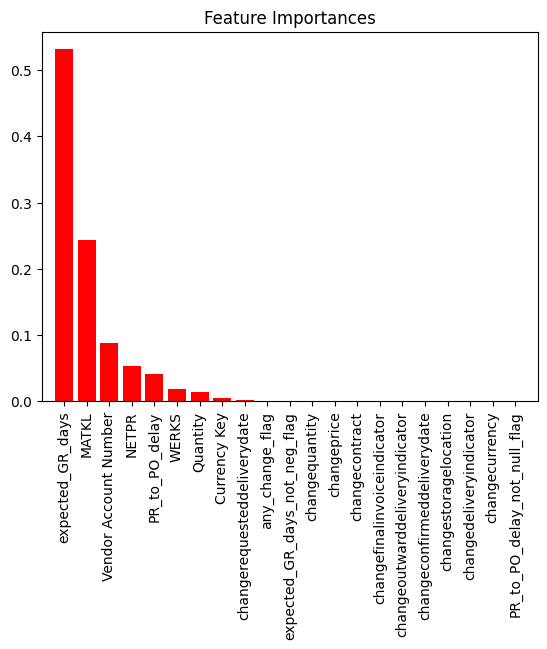

In [136]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5, n_jobs=-1)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predicting the Test set results
y_rf_pred = rf_model.predict(X_test)

# Calculate MSE and R²
mse_rf = mean_squared_error(y_test, y_rf_pred)
r2_rf = r2_score(y_test, y_rf_pred)

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R² Score: {r2_rf}')

# Feature importance visualization
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [137]:
data=merged_df.copy()

# Create a new column for normalized values
data['NETPR_normalized'] = data['NETPR'] * data['Exchange Rate']

# Apply log transformation to the normalized values
data['NETPR_normalized_log'] = np.log(data['NETPR_normalized'])

# Apply scaling to the normalized values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['NETPR_normalized_scaled'] = scaler.fit_transform(data['NETPR_normalized'].values.reshape(-1, 1))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd

# Assume 'data' is your preprocessed DataFrame

# Encode categorical variables
label_encoders = {}
for column in ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# Prepare the features and target variable
X = data[['expected_GR_days', 'Vendor Account Number', 'MATKL', 'NETPR_normalized_scaled', 
          'Currency Key', 'Quantity', 'WERKS'] + 
          ['changerequesteddeliverydate', 'changeprice', 'changequantity', 
          'changecurrency', 'changedeliveryindicator', 'changefinalinvoiceindicator', 
          'changestoragelocation', 'changeconfirmeddeliverydate', 
          'changecontract', 'changeoutwarddeliveryindicator']]
y = data['GR_delay_log']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Calculate RMSE
rmse = (mean_squared_error(y_test, y_pred))

print(f'Root Mean Squared Error: {rmse}')





C:\Users\bolusani\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Root Mean Squared Error: 0.5149463307021226


Linear regression

In [133]:
data=merged_df.copy()
# Apply log transformation to the normalized values
data['NETPR_normalized_log'] = np.log(data['NETPR_normalized'])
# Apply scaling to the normalized values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['NETPR_normalized_scaled'] = scaler.fit_transform(data['NETPR_normalized'].values.reshape(-1, 1))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
# Encode categorical variables
label_encoders = {}
for column in ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le
#data=data[(data['PR_to_PO_delay_not_null_flag']!=0) & (data['expected_GR_days_not_neg_flag']!=0)]
data = data[(data['GR_delay_bin'] >= -9) & (data['GR_delay_bin'] <= 18)]

C:\Users\bolusani\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


total records in data 71567
MSE: 0.8758260734706106, RMSE: 0.9358557973697714, MAE: 0.6896730958644438, R²: 0.035258757413196506
Cross-validated RMSE: 0.9331052086712235


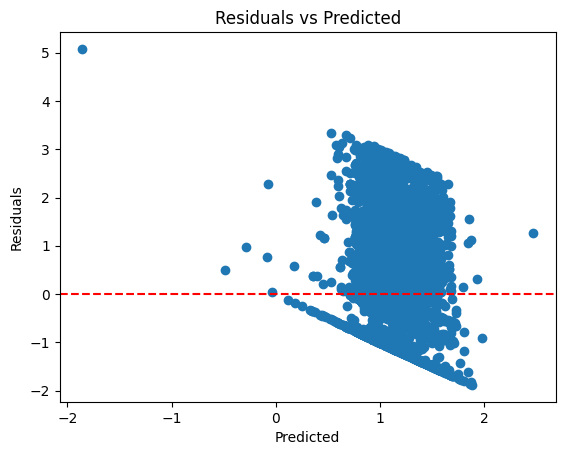

In [134]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Load and preprocess the data
categorical_features = ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']

# Concatenate encoded df with the rest of the data
numerical_features = ['expected_GR_days', 'NETPR', 'Quantity', 'PR_to_PO_delay'] + \
    ['changerequesteddeliverydate', 'changeprice', 'changequantity', 'changecurrency', 
     'changedeliveryindicator', 'changefinalinvoiceindicator', 'changestoragelocation', 
     'changeconfirmeddeliverydate', 'changecontract', 'changeoutwarddeliveryindicator','PR_to_PO_delay_not_null_flag',
       'expected_GR_days_not_neg_flag']

print("total records in data",data.shape[0])
final_data_regression = data[numerical_features + categorical_features]
Y = data['GR_delay_log']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_data_regression, Y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}")
print(f"Cross-validated RMSE: {cv_rmse_scores.mean()}")

# Residual plots
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


all

In [160]:
data=merged_df.copy()
change_columns = [
    "changeconfirmeddeliverydate", "changecontract", "changecurrency", 
    "changedeliveryindicator", "changefinalinvoiceindicator", 
    "changeoutwarddeliveryindicator", "changeprice", "changequantity", 
    "changerequesteddeliverydate", "changestoragelocation"
]

# Create 'any_change_flag' by summing up all the change columns
data['any_change_flag'] = data[change_columns].sum(axis=1)
# Apply log transformation to the normalized values
data['NETPR_normalized_log'] = np.log(data['NETPR_normalized'])
# Apply scaling to the normalized values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['NETPR_normalized_scaled'] = scaler.fit_transform(data['NETPR_normalized'].values.reshape(-1, 1))
data['any_change_flag'] = data[change_columns].sum(axis=1)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
# Encode categorical variables
label_encoders = {}
for column in ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le
#data=data[(data['PR_to_PO_delay_not_null_flag']!=0) & (data['expected_GR_days_not_neg_flag']!=0)]
data = data[(data['GR_delay_bin'] >= -9) & (data['GR_delay_bin'] <= 18)]
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Load and preprocess the data
categorical_features = ['Vendor Account Number', 'MATKL', 'Currency Key', 'WERKS']

# Concatenate encoded df with the rest of the data
numerical_features = ['expected_GR_days', 'NETPR', 'Quantity', 'PR_to_PO_delay'] + \
    ['any_change_flag','changerequesteddeliverydate', 'changeprice', 'changequantity', 'changecurrency', 
     'changedeliveryindicator', 'changefinalinvoiceindicator', 'changestoragelocation', 
     'changeconfirmeddeliverydate', 'changecontract', 'changeoutwarddeliveryindicator','PR_to_PO_delay_not_null_flag',
       'expected_GR_days_not_neg_flag']

print("total records in data",data.shape[0])
final_data_regression = data[numerical_features + categorical_features]
#Y = data['GR_delay_bin'].astype(int)
Y = data['GR_delay_log']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_data_regression, Y, test_size=0.2, random_state=42)


total records in data 71567


C:\Users\bolusani\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [154]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import numpy as np

# Define the preprocessor
preprocessor = StandardScaler()

# Define the models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'SVR': SVR()
}

# Iterate over the models
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"{name}: Mean CV MSE: {np.mean(cv_scores)}")

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'SVR': SVR()
}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"{name}: Mean CV MSE: {np.mean(cv_scores)}")
    


LinearRegression: Mean CV MSE: -0.870626882211825
Ridge: Mean CV MSE: -0.8706601235174322
Lasso: Mean CV MSE: -0.9022994066093408
RandomForestRegressor: Mean CV MSE: -0.4101496082993804
GradientBoostingRegressor: Mean CV MSE: -0.6288426098224388


KeyboardInterrupt: 

In [161]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR



# Define the preprocessor as a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'SVR': SVR()
}

# Define K-fold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store the results
results = {}

# Iterate over the models
for name, model in models.items():
    # Prepare lists to store metrics for each fold
    mse_scores = []
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    
    # Start cross-validation for each model
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Create and fit the pipeline on the training data
        pipeline = Pipeline(steps=[('regressor', model)])
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Predict on the test data
        y_pred = pipeline.predict(X_test_fold)
        
        # Calculate metrics
        mse = mean_squared_error(y_test_fold, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_fold, y_pred)
        r2 = r2_score(y_test_fold, y_pred)
        
        # Append scores
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
    
    # Store average of the metrics
    results[name] = {
        'Mean CV MSE': np.mean(mse_scores),
        'Mean CV RMSE': np.mean(rmse_scores),
        'Mean CV MAE': np.mean(mae_scores),
        'Mean CV R²': np.mean(r2_scores)
    }

# Display the results
for name, metrics in results.items():
    print(f"{name} Performance:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")
    print()  # For better readability


LinearRegression Performance:
  Mean CV MSE: 0.8707607612535803
  Mean CV RMSE: 0.9331052086712235
  Mean CV MAE: 0.6910124683031859
  Mean CV R²: 0.03486465215143815

Ridge Performance:
  Mean CV MSE: 0.8707706003865902
  Mean CV RMSE: 0.9331103780917609
  Mean CV MAE: 0.6910228951094772
  Mean CV R²: 0.03485433859497755

Lasso Performance:
  Mean CV MSE: 0.8839530239051397
  Mean CV RMSE: 0.9401435527699796
  Mean CV MAE: 0.7097666091571838
  Mean CV R²: 0.020258649597984024

RandomForestRegressor Performance:
  Mean CV MSE: 0.40985081497993103
  Mean CV RMSE: 0.6400544968004769
  Mean CV MAE: 0.3321749156994421
  Mean CV R²: 0.545874512801362

GradientBoostingRegressor Performance:
  Mean CV MSE: 0.6266317653456862
  Mean CV RMSE: 0.7915662897340058
  Mean CV MAE: 0.5040380143620764
  Mean CV R²: 0.3054480778911931

SVR Performance:
  Mean CV MSE: 0.9484376562545285
  Mean CV RMSE: 0.9738366921779834
  Mean CV MAE: 0.6546686263530554
  Mean CV R²: -0.051236282495652305



Classification

In [ ]:
final_data_classification = data[['expected_GR_days', 'Vendor Account Number', 'MATKL', 'NETPR_normalized_scaled', 
          'Currency Key', 'Quantity', 'WERKS'] + 
          ['changerequesteddeliverydate', 'changeprice', 'changequantity', 
          'changecurrency', 'changedeliveryindicator', 'changefinalinvoiceindicator', 
          'changestoragelocation', 'changeconfirmeddeliverydate', 
          'changecontract', 'changeoutwarddeliveryindicator','GR_delay_flag']]
final_data_classification.to_csv('final_data_classification.csv', index=False)
